# Making figures with python

In this script I'll go over a template for making figures. The script is laid out in such a way that panels can be developed individually. 

This notebook has the following components:
 
- <a href='#dataanalysis'>Data analysis</a>
- <a href='#singlepanels'>Developing individual panels</a>  
- <a href='#assembly'>Figure assembly</a>

### Initialize figure size and path

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pathlib
import os 
import pickle 

# define path to figure and data folders
figs_path = pathlib.Path.cwd().parent.joinpath('figs') 
data_path = pathlib.Path.cwd().parent.joinpath('data') 

# set final figure dimensions (in inches)
full_width = 6.8
half_width = 3.5 
fig_height = 2.0

# set fraction of final figure for every panel
p1_width = 0.4
p1_hpad = 0.15
p2_width = 0.55

<a id='dataanalysis'></a>
# Data analysis 

Here I'll create some sample data to plot. Generally this would happen in a separate script from plotting because we want to be able to execute the plotting very quickly. To demonstrate separation of analysis and plotting I'm saving the data in a data folder. 

### Create signal

In [2]:
time_end = 1
samp_freq = 0.001
time = np.arange(0,time_end+samp_freq,samp_freq)

# set seed to get same set of random numbers
np.random.seed(0)

freq_min = 1
freq_max = 50
freq_instances = 10 
frequencies = np.array([3, 11, 19, 24, 41])
frequency_amplitudes = np.random.rand(freq_instances)

signal = np.zeros(len(time)) 
for freq, amp in zip(frequencies, frequency_amplitudes): 
    signal = signal + amp*np.sin(2*np.pi*freq*time)     

### Frequency analysis of signal

In [3]:
tpCount     = len(signal)  
fft = np.fft.fft(signal)/len(signal)
fft = fft[:int(tpCount/2+1)] 
values      = np.arange(int(tpCount/2+1))
timePeriod  = tpCount/samp_freq
k = values 
fft_amp = np.abs(fft)*2 

### Save data

In [4]:
data_dict = {'time':time, 'signal':signal,'freq':k,'amp':fft_amp}

filename = os.path.join( data_path, 'frequency_analysis_data.pickle') 
with open(filename, 'wb') as handle:
    pickle.dump(data_dict, handle) 

<a id='singlepanels'></a>
# Developing individual panels

As mentioned above, I generally do the data analysis in a different script so I've included a block with loading data. 

### Load data with picke

In [5]:
filename = os.path.join( data_path, 'frequency_analysis_data.pickle')
with open(filename, 'rb') as handle:
    data_dict = pickle.load(handle)

time = data_dict.get('time')
signal = data_dict.get('signal')
k = data_dict.get('freq')
fft_amp = data_dict.get('amp')

### Develop panel 1 (plot signal)

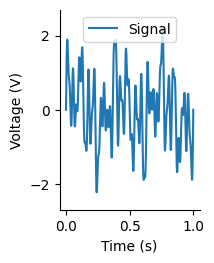

In [6]:
def plot_sin( ax_function, x, y):
            
    ax_function.plot(x, y, label='Signal')
    
    y_limits = np.array([ np.min(y), np.max(y) ])
    ylim_round = np.round(y_limits*1.2,1)
    ax_function.set_ylim(ylim_round)
    
    ytick_limits = np.round(y_limits*1.1)
    yticks = np.linspace(ytick_limits[0], ytick_limits[1], 3)
    ax_function.set_yticks(yticks)
    
    spines_toset_invisible = ['top','right']
    for spine in spines_toset_invisible:
        ax_function.spines[spine].set_visible(False)
        
    ax_function.set_xlabel('Time (s)')
    ax_function.set_ylabel('Voltage (V)')
    
    ax_function.legend(loc='upper center')
          
        
fig = plt.figure(figsize=(half_width,fig_height),
                 dpi = 100)   
ax0= plt.axes([0, 0,
               p1_width, 1] )  

plot_sin( ax0 , time, signal)

### Develop panel 2 (plot frequency spectrum)

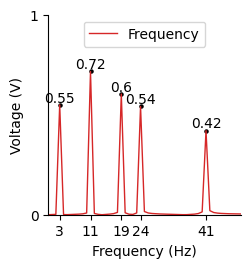

In [7]:
def plot_fft( ax_function, x, y):
    
    next_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][3]
    ax_function.plot(x, y, 
                     label='Frequency',
                    linewidth = 1,
                    color=next_color)

    ax_function.set_xlim([0,50])
    
    y_limits = np.array([ np.min(y), np.max(y) ])
    ylim_round = np.round(y_limits*1.2)
    ax_function.set_ylim(ylim_round)
    
    threshold = 0.1 
    bool_above_threshold = y > 0.1
    
    xticks = x[bool_above_threshold]
    ax_function.set_xticks(xticks)
        
    ytick_limits = np.round(y_limits*1.1)
    yticks = np.linspace(ytick_limits[0], ytick_limits[1], 2)
    ax_function.set_yticks(yticks)
    
    spines_toset_invisible = ['top','right']
    for spine in spines_toset_invisible:
        ax_function.spines[spine].set_visible(False)
        
    ax_function.set_xlabel('Frequency (Hz)')
    ax_function.set_ylabel('Voltage (V)')
    
    ypeaks = y[bool_above_threshold]
    for xpeak, ypeak in zip(xticks,ypeaks): 
        ax_function.annotate( np.round(ypeak,2), 
                             [xpeak, ypeak],
                            ha='center',va='bottom')
        ax_function.scatter(xpeak,ypeak,5,'k')
    
    ax_function.legend(loc='upper center')
         

fig = plt.figure(figsize=(half_width,fig_height),
                 dpi = 100)  
ax0= plt.axes([0, 0,
               p2_width, 1] )   

plot_fft(ax0, k, fft_amp) 

<a id='assembly'></a>
# Figure assembly

### Combine panels into final figure

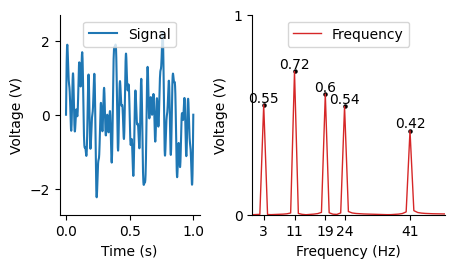

In [8]:
# p1_width = 0.4
# p1_hpad = 0.15
# p2_width = 0.55
# fig_height = 2

fig = plt.figure(figsize=(half_width,fig_height),
                 dpi = 100)
ax0= plt.axes( [0, 0,
               p1_width, 1] )  
ax1= plt.axes( [p1_width+p1_hpad, 0,
               p2_width, 1] )   

plot_sin(ax0, time, signal)
plot_fft(ax1, k, fft_amp)

### Save figure

In [10]:
fig_name = pathlib.Path('figure_example_fig1')

def save_fig(fig, figs_dir, fig_name ): 
    fig_pathname = os.path.join( figs_dir, fig_name )  
    
    print('Saving to: {}.svg '.format( fig_pathname))  
    
    fig.savefig( fig_pathname + '.png',
            format='png',  transparent= True,
            bbox_inches = 'tight', pad_inches = 0,
            )   
    
    fig.savefig( fig_pathname + '.pdf',
            format='pdf',  transparent= True,
            bbox_inches = 'tight', pad_inches = 0,
            )   
    
    fig.savefig( fig_pathname + '.svg',
            format='svg',  transparent= True,
            bbox_inches = 'tight', pad_inches = 0,
            )   
    
save_fig(fig, figs_path, fig_name)

Saving to: /home/thomas/Projects/scientific_figures/figs/figure_example_fig1.svg 
